Crop yield data is arguably the most important measure of agricultural productivity and production, and is used to monitor global and national food security, and to help determine effective agricultural policy.

Due to the physical challenges and high costs associated with the collection of crop-cut yield estimates, few datasets exist and even fewer are regularly sampled every season. For this reason, developing new methods to estimate crop yields at scale using the limited data available has been a prominent research priority.

One of the most promising yield estimation methods has been to use available crop-cut datasets to calibrate mathematical models to estimate crop yields from satellite imagery.

The aim of this challenge is to create a model capable of estimating the crop-cut maize yield for fields in East Africa. Given a time-series of Sentinel 2 imagery and climate variables, your model must output a predicted yield in tons per acre.

These models often need to be applied at scale, so large ensembles are discouraged. To incentivise more lightweight solutions, we are adding an additional submission criteria: your submission should take a reasonable time to train and run inference. Specifically, we should be able to re-create your submission on a single-GPU machine (eg Nvidia P100) with less than 8 hours training and two hours inference.

About CGIAR (cgiar.org):


The CGIAR (formerly the Consultative Group for International Agricultural Research) is a consortium of international agricultural research centers scattered across the world who focus on issues related to agricultural productivity, food security, poverty, and the environment. The CGIAR is made up of 15 research centers and operates in dozens of countries across Asia, Africa, and Latin America.

About The Platform for Big Data in Agriculture (bigdata.cgiar.org)


The CGIAR Platform for Big Data in Agriculture is a cross-center platform of the CGIAR with the goal of leveraging and harnessing the power of big data to accelerate and enhance the impact of international agricultural research. This 5-year platform (2017 - 2021) will provide global leadership in organizing open data, convening partners to develop innovative ideas, and demonstrating the power of big data analytics through inspiring projects. It is where information becomes power: power to predict, prescribe, and produce more food, more sustainably. It democratizes decades of agricultural data empowering analysts, statisticians, programmers and more to mine information for trends and quirks, and develop rapid, accurate and compelling recommendations for farmers, researchers and policymakers.

About The Big Data in Agriculture Convention (bigdata.cgiar.org/virtual-convention-2020)

This year’s Convention will be held online from 19 - 23 October, with the theme of digital dynamism for adaptive food systems.

This convention is the third annual event to bring together the people and organizations that make the Big Data Platform successful, a mix of scientists, policy makers, entrepreneurs, technologists, and agriculturalists. Three days of focused, action-based discussion to find commonalities across research institutes, governments, and private organizations sets the stage for a productive and data-driven year ahead!

About The Alliance of Bioversity and the International Center for Tropical Agriculture (CIAT) (bioversityinternational.org/alliance)


CIAT (International Center for Tropical Agriculture) works in collaboration with hundreds of partners to help developing countries make farming more competitive, profitable, and resilient through smarter, more sustainable natural resource management. We help policymakers, scientists, and farmers respond to some of the most pressing challenges of our time, including food insecurity and malnutrition, climate change, and environmental degradation.

About The International Food Policy Research Institute (IFPRI) (ifpri.org)


The International Food Policy Research Institute (IFPRI) provides research-based policy solutions to sustainably reduce poverty and end hunger and malnutrition in developing countries. Established in 1975, IFPRI currently has more than 600 employees working in over 50 countries. It is a research center of CGIAR, a worldwide partnership engaged in agricultural research for development.

About Amazon Web Services (https://aws.amazon.com)


Amazon Web Services (AWS) is the world’s most comprehensive and broadly adopted cloud platform, offering over 175 fully featured services from data centers globally, including Cape Town, South Africa. Millions of customers, including academic and research institutions like CGIAR, are using AWS to lower costs, become more agile, and innovate faster.

**This is my first CNN based model using pytorch**

Please upvote if you like it and open for suggestions

* This kernel is an overvew of out the CNN approach
* Please make the changes to the dataset paths based on your needs
* The prediction on the test data as to be done separately as the GPU memory is not getting clearing after training and validation datasets(still exploring this)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Train.csv has the Field_IDs needed to find the npy files
train = pd.read_csv('Train.csv')
train.head()

,Field_ID,Year,Quality,Yield
0,MH2O0YH,2019,3,3.686
1,O9TURWL,2019,2,5.657
2,35AFSDD,2019,3,3.082
3,PM05EG9,2019,2,2.707
4,V7PZBCG,2019,2,2.679


Loading image_arrays_train/I9YGV3U.npy as an array
Array shape: (360, 41, 40)


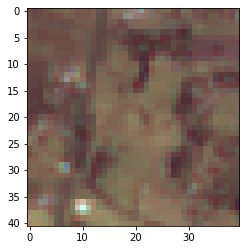

In [3]:
# Look at a sample:
fid = train['Field_ID'].sample().values[0]
fn = f'image_arrays_train/{fid}.npy' # File name based on Field_ID
print(f'Loading {fn} as an array')
arr = np.load(fn) # Loading the data with numpy
print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
rgb_jan = np.stack([arr[4], arr[3], arr[2]], axis=-1) # Combine three bands for viewing
rgb_jan = rgb_jan / np.max(rgb_jan) # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_jan) # View with matplotlib

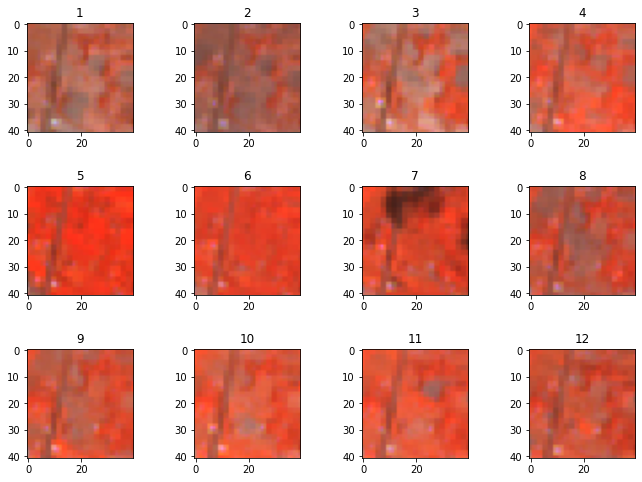

In [4]:
# View false colour images from each month in the year:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  rgb = np.stack([arr[i*30 + 8], arr[i*30 + 4], arr[i*30 + 3]], axis=-1) # False colour (band 8, 4 and 3)
  rgb = rgb / 4000 # Scaling consistently 
  axs[i].imshow(rgb.clip(0, 1))
  axs[i].set_title(str(i+1))

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

**Splitting the data**

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train['Field_ID'], train['Yield'], random_state=42)


In [7]:
batch_size =128
n_epochs = 20

**Data Loader for train and validation sets**

In [8]:
class CropYield(Dataset):
    def __init__(self, df, target, folder, transform=None):
        self.df = df
        self.length = len(df)
        self.transform = transform
        self.folder = folder
        self.target = target
    def __getitem__(self, index):
        img = np.load(f'{self.folder}/{self.df[index]}.npy').astype(np.float64)
        img.resize(360, 32, 32) # Reshaping the image to a 32* 32 px 

        # if not self.transform:
        img = torch.from_numpy(img)
        return img, torch.tensor(self.target[index])
    def __len__(self):
        return self.length

In [9]:
training_set = CropYield(X_train.reset_index(drop=True), y_train.reset_index(drop=True), 'image_arrays_train')
validation_set  = CropYield(X_test.reset_index(drop=True), y_test.reset_index(drop=True), 'image_arrays_train')


In [10]:
train_loader = DataLoader(training_set, batch_size, shuffle=True)
validation_set = DataLoader(validation_set, batch_size=len(X_test), shuffle=True)

**CNN model**

In [11]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=360, out_channels=450, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels= 450, out_channels = 200, kernel_size=3, padding=1)
    self.linear1 = nn.Linear(in_features=200*6*6, out_features=256)
    self.dropout1 = nn.Dropout(0.4)
    self.linear2 = nn.Linear(in_features=256, out_features=128)
    self.dropout2 = nn.Dropout(0.4)
    self.linear3 =  nn.Linear(in_features=128, out_features=64)
    self.dropout3 = nn.Dropout(0.4)
    self.out = nn.Linear(in_features=64, out_features=1)

  def forward(self, t):
    #layer1
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=4, stride=2)
    #layer2
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=5, stride=2)
    #Flatten and layer3 
    t = t.reshape(-1, 200 * 6 * 6)
    t = self.linear1(t)
    t = F.relu(t)
    #Layer4
    t = self.dropout1(t)
    #layer5
    t= self.linear2(t)
    t = F.relu(t)
    #layer6
    t =self.dropout2(t)
    #layer7
    t = self.linear3(t)
    t = F.relu(t)
    #layer8
    t = self.dropout3(t)
    #output
    return self.out(t)

In [12]:
model = Net()
model.double()
optimizer = optim.Adam(model.parameters(), lr=0.01)
model.to('cuda')

AssertionError: Torch not compiled with CUDA enabled

**Training**

In [ ]:

for i in range(n_epochs):
  total_loss = 0
  for batch in train_loader: # Get Batch
    images, values = batch 
#     images = images.to('cuda')  # missing line from original code
#     values = values.to('cuda')
    preds = model(images) # Pass Batch
    mse_loss = nn.MSELoss()
    loss = mse_loss(preds.reshape(values.shape[0]), values) # Calculate Loss

    optimizer.zero_grad()
    loss.backward() # Calculate Gradients
    optimizer.step() # Update Weights
    total_loss += loss.item()

  print(
      
      "epoch:", i,  
      "loss:", total_loss/len(train_loader)
  ) 


epoch: 0 loss: 1173762770223.584
epoch: 1 loss: 29686.758334268332
epoch: 2 loss: 7968.815928523476
epoch: 3 loss: 11962.98687385863
epoch: 4 loss: 2322.364069479657


In [ ]:
torch.save(model.state_dict(), 'model.pth')


**Validation**

In [ ]:
for each in validation_set:
    images, values = each 
    images = images.to('cuda')  # missing line from original code
    values = values.to('cuda')
    #optimizer = optimizer
    valid_preds = model(images) # Pass Batch
    mse_loss = nn.MSELoss()
    loss = mse_loss(valid_preds.reshape(values.shape[0]), values)
    print(loss)

**Testing**

In [ ]:
ss = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/crop yield/SampleSubmission.csv')
test_set  = CropYield(ss['Field_ID'].reset_index(drop=True), ss['Yield'].reset_index(drop=True), 'image_arrays_test')
test_loader = DataLoader(test_set, len(ss))

In [ ]:
model.load_state_dict(torch.load('model.pth'))


In [ ]:

for each in test_loader:
    images, values = each 
    images = images.to('cuda')  # missing line from original code
    values = values.to('cuda')
    #optimizer = optimizer
    test_values = model(images) # Pass Batch
    

In [ ]:
test_values = test_values.cpu()

In [ ]:
ss['Yield'] = test_values.detach().numpy()

In [ ]:
ss.to_csv('Sub.csv', index=False)
